In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import time
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import imageio
from IPython.display import Image

In [2]:
class DQN(nn.Module):
    def __init__(self, input_features, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(input_features, input_features*4)
        self.out = nn.Linear(input_features*4, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


In [3]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.buffer.append(transition)

    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
def encode_game_state(desc, agent_index):
    
    # start S -> 0, frozen tile F -> 0, hole H -> -1, goal G -> 2
    tile_mapping = {'S': 0.0, 'F': 0.0, 'H': -1.0, 'G': 2.0}
    
    # agent -> 1
    agent_marker = 1.0

    encoded_state = []

    # describtion durchgehen und buchstaben in entsprechende ziffer codieren
    for row in desc:
        for tile in row:
            encoded_state.append(tile_mapping[tile])
    
    encoded_state[agent_index] = agent_marker

    # in tensor umwandeln
    encoded_state = torch.FloatTensor(np.array(encoded_state))
   
    return encoded_state

In [5]:
# hyperparameter
learning_rate = 0.001
discount_factor = 0.9
network_sync_rate = 50
max_buffer_size = 50000
mini_batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train(episodes, lake_size, desc, is_slippery=False):
        
    start_time = time.time()

    buffer = ReplayBuffer(max_buffer_size)

    num_lake_tiles = lake_size * lake_size
    num_actions = 4

    # policy und target network erstellen
    policy_dqn = DQN(input_features=num_lake_tiles, out_actions=num_actions).to(device)
    target_dqn = DQN(input_features=num_lake_tiles, out_actions=num_actions).to(device)

    # target network und policy network gleich machen
    target_dqn.load_state_dict(policy_dqn.state_dict())

    # target network nur für inferenz gebraucht
    target_dqn.eval()

    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate)

    rewards_per_episode = []
    epsilon_history = []
    losses = []

    total_steps = 0
    epsilon = 1.0

    # fixen lake erstellen
    env = gym.make('FrozenLake-v1', desc=desc, is_slippery=is_slippery, render_mode=None)

    for episode in range(episodes):
        
        state, _ = env.reset()

        current_state_tensor = encode_game_state(desc, state).to(device)

        terminated = False
        truncated = False
        episode_reward = 0
        steps_in_episode = 0 

        epsilon_history.append(epsilon)

        while(not terminated and not truncated):
            # aktion nach epsilon greedy wählen
            if random.random() < epsilon:
                action = env.action_space.sample()  # zufällig
            else:          
                with torch.no_grad():
                    q_values = policy_dqn(current_state_tensor).to(device)
                    action = torch.argmax(q_values).item()  # beste

            # step
            new_state, reward, terminated, truncated, _ = env.step(action)
            
            next_state_tensor = encode_game_state(desc, new_state).to(device)

            # im buffer speichern
            buffer.append((state, action, new_state, reward, terminated, desc))
            
            state = new_state
            current_state_tensor = next_state_tensor
            
            episode_reward += reward 
            steps_in_episode += 1
            total_steps += 1

            # falls genug sample im buffer dann erst lernen
            if len(buffer) > mini_batch_size:
                mini_batch = buffer.sample(mini_batch_size)
                loss = optimize(mini_batch, policy_dqn, target_dqn, optimizer)
                if loss is not None:
                     losses.append(loss.item())

                # target network synchronisieren
                if total_steps % network_sync_rate == 0:
                    target_dqn.load_state_dict(policy_dqn.state_dict())


        rewards_per_episode.append(episode_reward) 
        
        # epsilon über zeit reduzieren
        epsilon = max(0.05, epsilon * 0.995)

        # log ausgabe alle 100 episoden
        if episode % 100 == 0:
             print(f"Episode {episode}/{episodes} | Episode Reward: {episode_reward:.3f} | Epsilon: {epsilon:.3f} | Steps: {steps_in_episode} | Buffer Size: {len(buffer)}")


    # training fertig
    env.close()
    end_time = time.time()
    print(f"Training fertig nach {end_time - start_time:.2f} Sekunden")

    # policy network speichern
    torch.save(policy_dqn.state_dict(), f"saved_model_dql_fixed_{lake_size}x{lake_size}.pt")

    return rewards_per_episode, losses, epsilon_history


In [7]:
def optimize(mini_batch, policy_dqn, target_dqn, optimizer):

    # daten aus mini batch extrahieren
    # (state, action, new_state, reward, terminated, desc)
    states = np.array([t[0] for t in mini_batch])
    actions = torch.LongTensor([t[1] for t in mini_batch]).view(-1, 1).to(device)
    next_states = np.array([t[2] for t in mini_batch])
    rewards = torch.FloatTensor([t[3] for t in mini_batch]).to(device)
    terminated_flags = torch.BoolTensor([t[4] for t in mini_batch]).to(device)
    descs = [t[5] for t in mini_batch]

    # alle game states encoden
    current_state_tensors = torch.stack([encode_game_state(desc, state) for desc, state in zip(descs, states)]).to(device)
    next_state_tensors = torch.stack([encode_game_state(desc, state) for desc, state in zip(descs, next_states)]).to(device)

    # q values für die actionen aus policy network bekommen
    current_q_values = policy_dqn(current_state_tensors).gather(1, actions).squeeze().to(device)

    # max q value aus target network bekommen
    with torch.no_grad():
         max_next_q_values = target_dqn(next_state_tensors).max(1)[0].to(device)

    # falls endzustand q value = 0
    max_next_q_values[terminated_flags] = 0.0

    # target q values berechnen
    target_q_values = rewards + (discount_factor * max_next_q_values).to(device)
    
    # l2 loss berechnen
    loss_fn = nn.MSELoss()
    loss = loss_fn(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss
    

In [8]:
def test(lake_size, desc, is_slippery=False):
        
    # versuche gespeichertes model zu laden
    model_filename = f"saved_model_dql_fixed_{lake_size}x{lake_size}.pt"
    
    num_lake_tiles = lake_size * lake_size
    num_actions = 4

    # modell laden
    policy_dqn = DQN(input_features=num_lake_tiles, out_actions=num_actions).to(device)
    policy_dqn.load_state_dict(torch.load(model_filename))
    
    policy_dqn.eval()

    success_count = 0

    # fixen lake erstellen
    env = gym.make('FrozenLake-v1', desc=desc, is_slippery=is_slippery, render_mode='rgb_array')
    
    state, _ = env.reset()
    terminated = False
    truncated = False
    frames = []

    # sonst fehlt erster frame
    frames.append(env.render())

    while(not terminated and not truncated):

        current_state_tensor = encode_game_state(desc, state).to(device)

        # beste aktion wählen
        with torch.no_grad():
            q_values = policy_dqn(current_state_tensor).to(device)
            action = torch.argmax(q_values).item()

        # aktion ausführen
        new_state, reward, terminated, truncated, _ = env.step(action)
        state = new_state

        frames.append(env.render())

    env.close()

    # gif speichern und anzeigen
    gif_path = f"dql_fixed_{lake_size}x{lake_size}.gif"
    imageio.mimsave(gif_path, frames, duration=1, loop=0)

    return gif_path


In [9]:
def plot_results(rewards_per_episode, losses, episodes, epsilon_history=[]):
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    sum_rewards = []
    for i in range(episodes):
        sum_rewards.append(np.sum(rewards_per_episode[max(0, i-100):(i+1)])/100)
    plt.plot(sum_rewards)
    plt.title('Avg Rewards pro 100 Episoden')
    plt.xlabel('Episoden')
    plt.ylabel('Avg Reward')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.title('Losses')
    plt.xlabel('Updates')
    plt.ylabel('Loss')
    plt.grid(True)
    
    if epsilon_history:
        plt.subplot(1, 3, 3)
        plt.plot(epsilon_history, color="red")
        plt.title('Epsilon Decay')
        plt.xlabel('Episoden')
        plt.ylabel('Epsilon')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


Episode 0/1000 | Episode Reward: 1.000 | Epsilon: 0.995 | Steps: 19 | Buffer Size: 19
Episode 100/1000 | Episode Reward: 0.000 | Epsilon: 0.603 | Steps: 22 | Buffer Size: 797
Episode 200/1000 | Episode Reward: 1.000 | Epsilon: 0.365 | Steps: 11 | Buffer Size: 1567
Episode 300/1000 | Episode Reward: 1.000 | Epsilon: 0.221 | Steps: 6 | Buffer Size: 2279
Episode 400/1000 | Episode Reward: 1.000 | Epsilon: 0.134 | Steps: 6 | Buffer Size: 2983
Episode 500/1000 | Episode Reward: 1.000 | Epsilon: 0.081 | Steps: 6 | Buffer Size: 3631
Episode 600/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 7 | Buffer Size: 4250
Episode 700/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 6 | Buffer Size: 4850
Episode 800/1000 | Episode Reward: 0.000 | Epsilon: 0.050 | Steps: 5 | Buffer Size: 5450
Episode 900/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 6 | Buffer Size: 6074
Training fertig nach 14.77 Sekunden


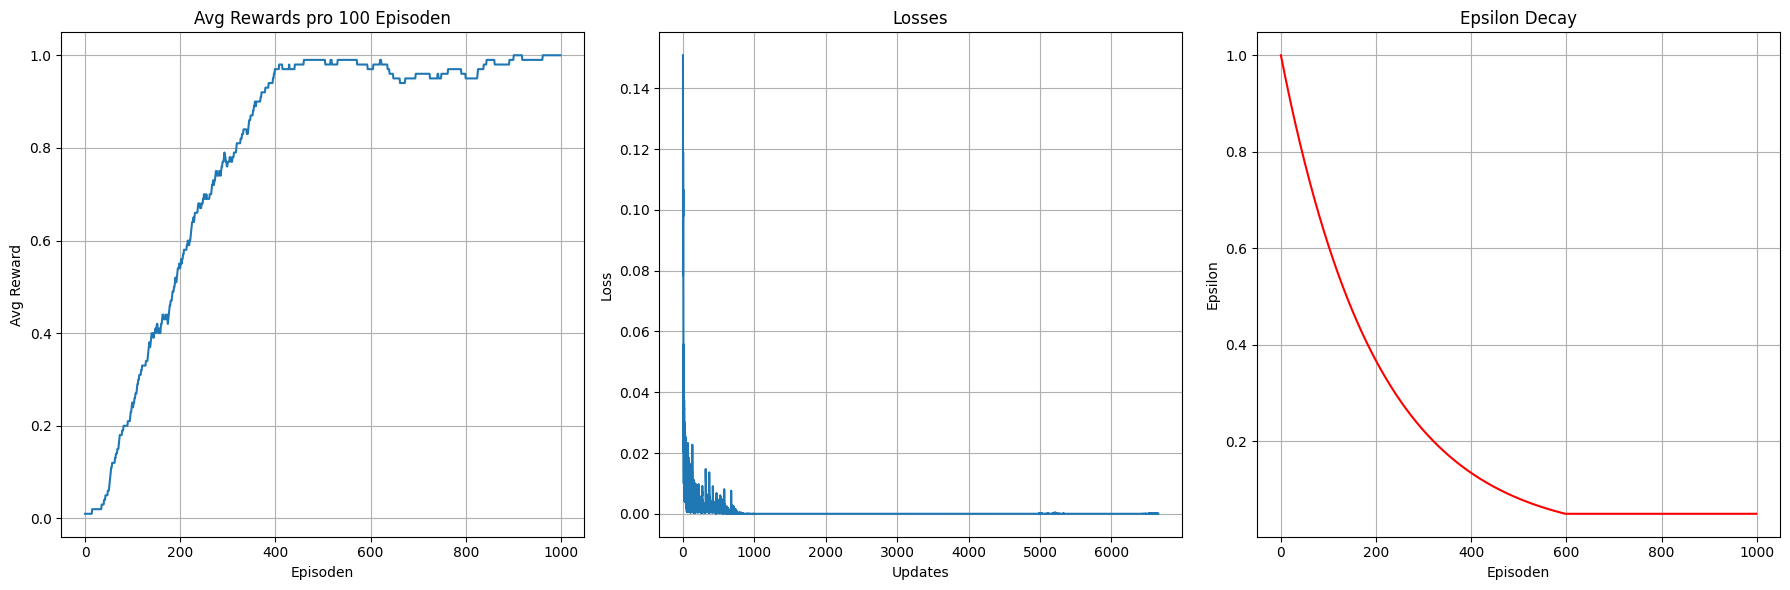

In [10]:
episodes = 1000
lake_size = 4

# damit für train und test der selbe lake generiert wird
desc = generate_random_map(size=lake_size)

# training starten
rewards_per_episode, losses, epsilon_history = train(episodes=episodes, desc=desc, lake_size=lake_size, is_slippery=False)

# metriken plotten
plot_results(rewards_per_episode, losses, episodes, epsilon_history)

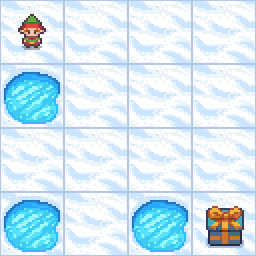

In [11]:
gif_path = test(lake_size=lake_size, desc=desc, is_slippery=False)

Image(filename=gif_path)

Episode 0/1000 | Episode Reward: 0.000 | Epsilon: 0.995 | Steps: 3 | Buffer Size: 3
Episode 100/1000 | Episode Reward: 0.000 | Epsilon: 0.603 | Steps: 13 | Buffer Size: 1252
Episode 200/1000 | Episode Reward: 1.000 | Epsilon: 0.365 | Steps: 16 | Buffer Size: 2671
Episode 300/1000 | Episode Reward: 1.000 | Epsilon: 0.221 | Steps: 16 | Buffer Size: 3993
Episode 400/1000 | Episode Reward: 1.000 | Epsilon: 0.134 | Steps: 14 | Buffer Size: 5395
Episode 500/1000 | Episode Reward: 1.000 | Epsilon: 0.081 | Steps: 14 | Buffer Size: 6804
Episode 600/1000 | Episode Reward: 0.000 | Epsilon: 0.050 | Steps: 8 | Buffer Size: 8245
Episode 700/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 14 | Buffer Size: 9655
Episode 800/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 14 | Buffer Size: 11075
Episode 900/1000 | Episode Reward: 1.000 | Epsilon: 0.050 | Steps: 14 | Buffer Size: 12498
Training fertig nach 29.31 Sekunden


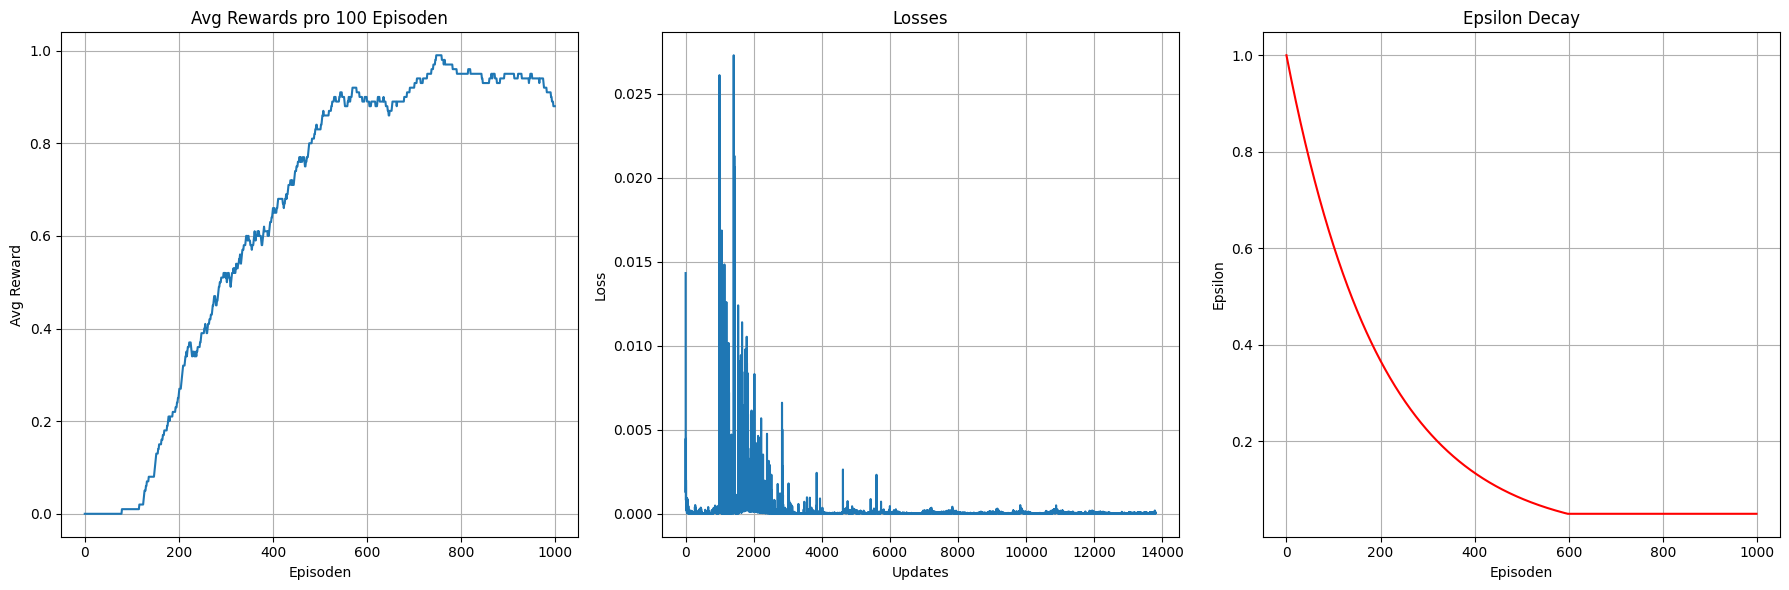

In [12]:
episodes = 1000
lake_size = 8

# damit für train und test der selbe lake generiert wird
desc = generate_random_map(size=8)

# training starten
rewards_per_episode, losses, epsilon_history = train(episodes=episodes, desc=desc, lake_size=lake_size, is_slippery=False)

# metriken plotten
plot_results(rewards_per_episode, losses, episodes, epsilon_history)

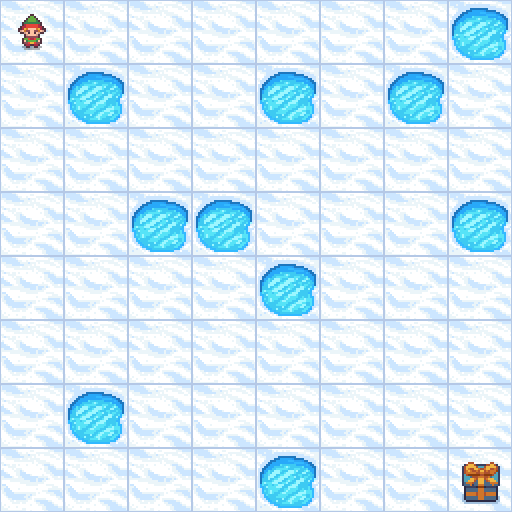

In [13]:
gif_path = test(lake_size=lake_size, desc=desc, is_slippery=False)

Image(filename=gif_path)